# Hierarchical Clustering
**Written by Christian Alis**

Representative-based clustering methods are flat clustering methods. You tell them to cluster data points into $k$ clusters and they will assign a point into exactly one cluster. Hierarchical clustering methods, on the other hand, assign points to a branch of a tree. Instead of having a priori value of $k$, it can be set after analysis, depending on where in the tree (hierarchy) you want to be.

There are two main types of hierarchical clustering:
* **Agglomerative clustering**: bottom-up approach where smaller clusters are merged with nearby clusters
* **Divisive clustering**: top-down approach where clusters are successively partitioned into smaller clusters

In this notebook, we will study four agglomerative clustering methods.

# Sample datasets

We will make use of the same datasets we investigated last time.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.testing.compare import compare_images
from sklearn.datasets import load_wine, fetch_20newsgroups
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA, TruncatedSVD
from scipy.spatial.distance import euclidean, cityblock
from IPython.display import HTML

In [2]:
data_wine = load_wine()
standard_scaler = StandardScaler()
X_wine = standard_scaler.fit_transform(data_wine['data'])
target_wine = data_wine['target']

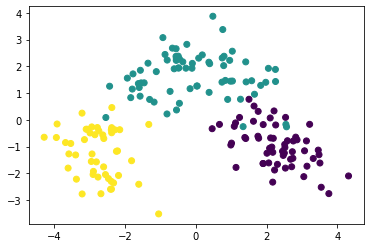

In [3]:
X_wine_new = PCA(n_components=2, random_state=1337).fit_transform(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=target_wine);

In [4]:
data_newsgroups = fetch_20newsgroups(
    subset='train', 
    categories=['comp.graphics', 'rec.autos'],
    shuffle=False, 
    remove=['headers', 'footers', 'quotes'])
tfidf_vectorizer = TfidfVectorizer(token_pattern=r'[a-z-]+', 
                                   stop_words='english',
                                   min_df=5)
bow_ng = tfidf_vectorizer.fit_transform(data_newsgroups['data'])
nonzeros = bow_ng.sum(axis=1).nonzero()[0]
bow_ng = bow_ng[nonzeros]
target_ng = data_newsgroups['target'][nonzeros]

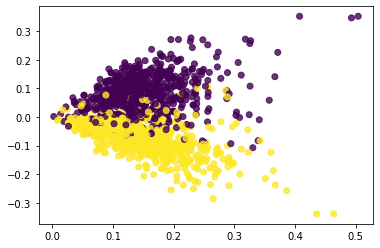

In [5]:
X_ng_new = (TruncatedSVD(n_components=2, random_state=1337)
                .fit_transform(bow_ng))
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=target_ng, alpha=0.8);

# Agglomerative clustering

This is the generic agglomerative clustering algorithm:

**Algorithm** *AgglomerativeClustering*(Database: $D$)  
**begin**  
$\quad$Initialize $n \times n$ distance metric $M$ using $D$;  
$\quad$Assign each $i \in D$ to its own cluster;  
$\quad$**repeat**  
$\quad$$\quad$Pick closest pair of clusters $i$ and $j$ using $M$;  
$\quad$$\quad$Merge clusters $i$ and $j$;  
$\quad$$\quad$Delete rows/columns $i$ and $j$ from $M$ and create a new row and column for newly merged cluster;  
$\quad$$\quad$Update the entries of new row and column of $M$;  
$\quad$**until** termination criterion;  
$\quad$**return** clustering;  
**end**

Different agglomerative clustering methods differ on how they compute the distance between clusters. The different cluster distance measures are:

* **Change in SSE**: increase in the sum-of-squared errors when the clusters are merged
* **Single linkage**: smallest distance between a point from one cluster to any point in the other cluster
* **Complete linkage**: farthest distance between a point from one cluster to any point in the other cluster
* **Group-average linkage**: average intercluster distance
* **Centroid**: distance between cluster centroids
* **Change in cluster variance**: increase in the objective function (cluster variance) when the clusters are merged

We will only discuss the first four measures in this notebook.

## Ward's method

The first agglomerative method that we will study is Ward's method. This method defines the distance between two clusters, $A$ and $B$, as the amount the sum of squares will increase when we merge them:

$$
\Delta(A, B) = \sum_{i \in A \bigcup B} \|x_i - m_{A \bigcup B}\|^2 - \sum_{i \in A} \|x_i - m_A\|^2 - \sum_{i \in B} \|x_i - m_B\|^2
$$

where $m_j$ is the center of cluster $j$, and $n_j$ is the number of points in it. $\Delta$ is the merging cost of combining the clusters $A$ and $B$. Starting from individual points as a cluster, the method merges them while trying to minimize the growth of $\Delta$. Given two pairs of clusters whose centers are equally far apart, Ward’s method will prefer to merge the smaller ones. Note that $\Delta$ always increases when we merge clusters.

We apply it to the wines dataset.

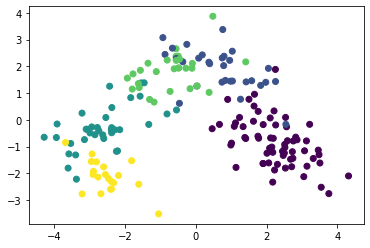

In [6]:
from sklearn.cluster import AgglomerativeClustering
agg = AgglomerativeClustering(n_clusters=5)
y_predict_wine = agg.fit_predict(X_wine)
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

A benefit of hierarchical clustering is that the number of clusters can be changed after performing the clustering. The number of clusters is usually selected based on a visualization (dendrogram) of the clustering hierarchy. Unfortunately, there's no function that we can use to plot the dendrogram of the `AgglomerativeClustering` class. Thus, we will use `scipy.cluster.hierarchy` functions for clustering and plotting the dendrogram.

In [19]:
from scipy.cluster.hierarchy import linkage, dendrogram
Z = linkage(X_wine, method='ward', optimal_ordering=True)

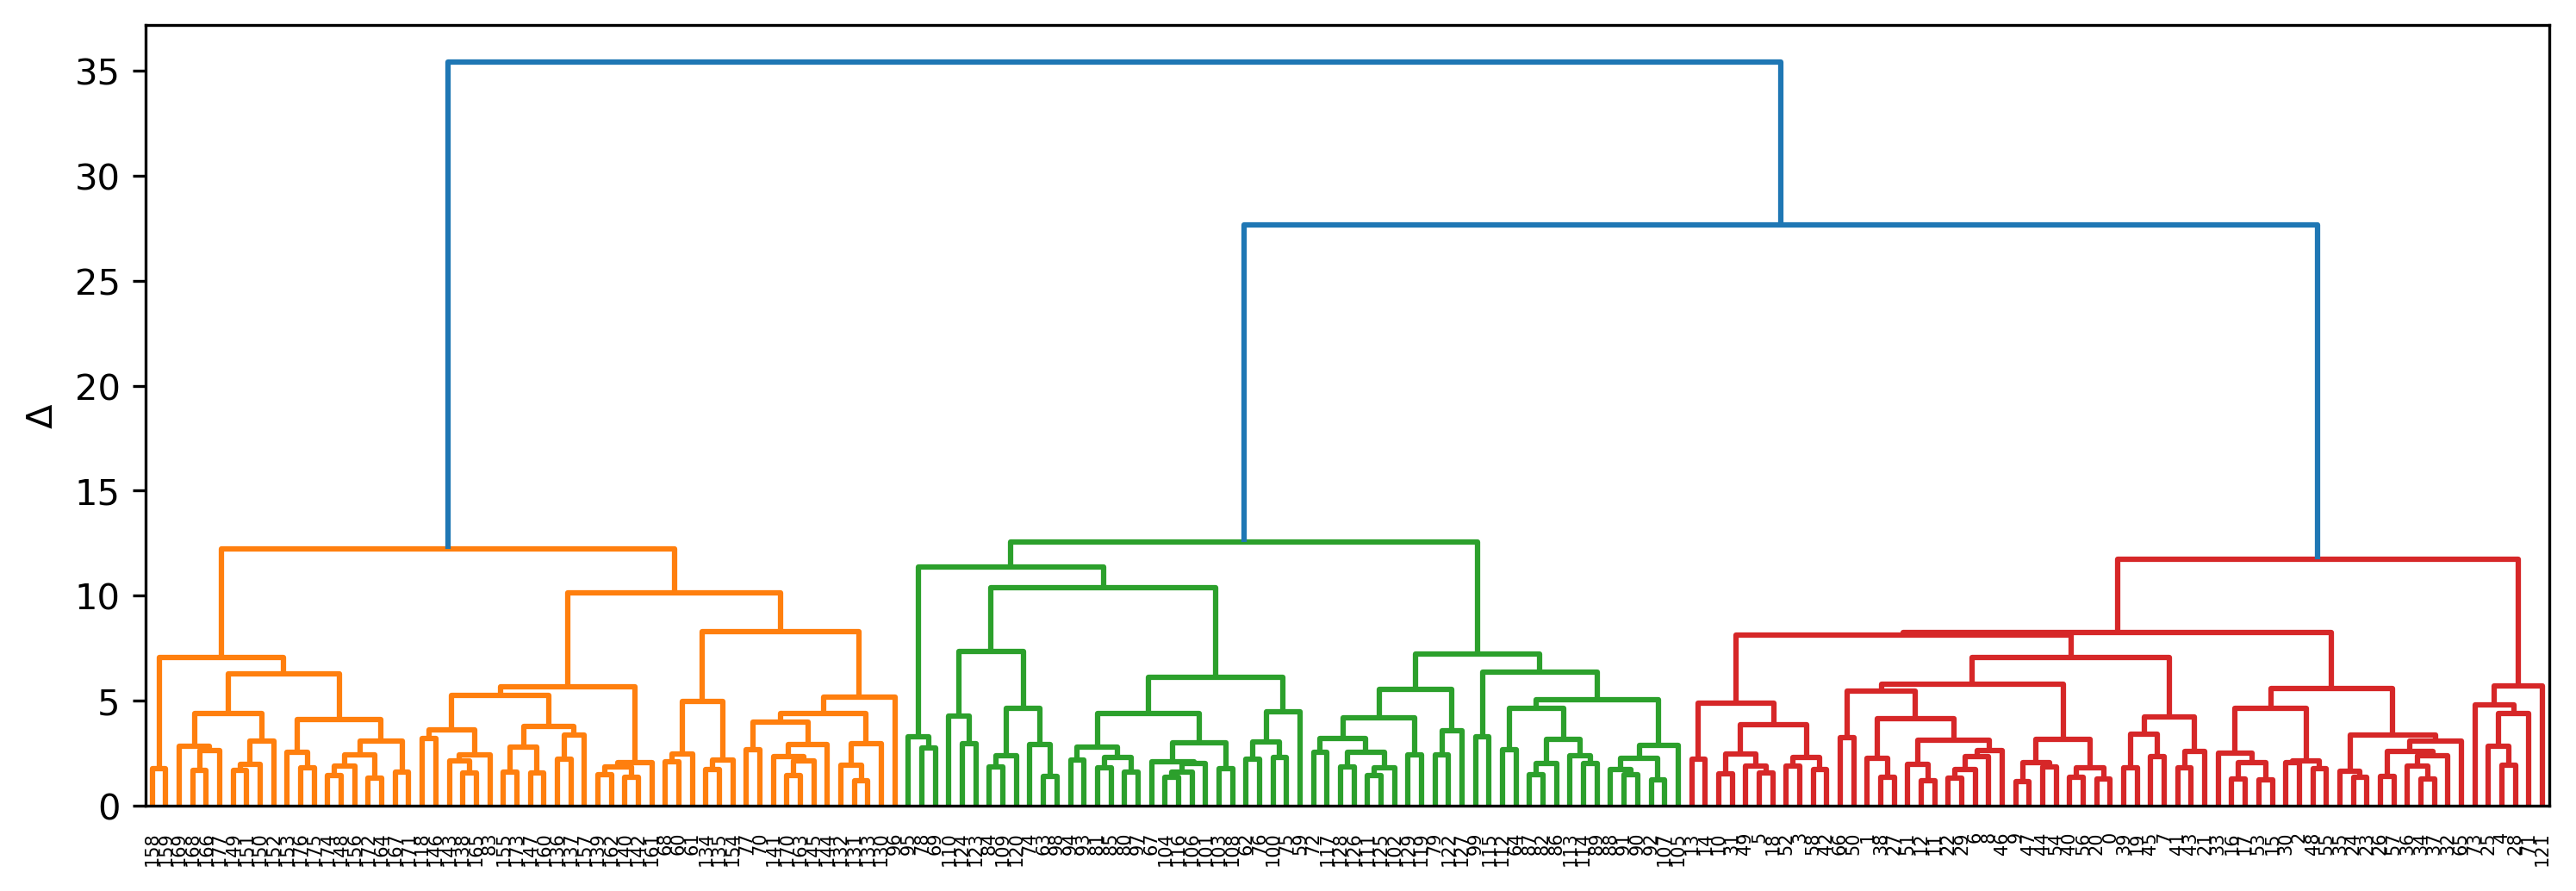

In [8]:
fig, ax = plt.subplots(figsize=(12,4), dpi=300)
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$\Delta$');

The dendrogram is too crowded so let's try to clean it up a bit.

**Exercise 14**

Create a function `plot1` that accepts the output of linkage and replicates the plot below.

![](plot1.png)

<img src='plot1.png'>

In [13]:
!pip install scipy

In [54]:
def plot1(Z):
    """Plot the dendogram of linkage.

    Parameters
    ----------
    Z : linkage matrix
    
    Returns
    -------
    dendogram plot
    """
    from scipy.cluster.hierarchy import linkage, dendrogram
    Z = linkage(X_wine, method='average', optimal_ordering=True)

    p = 20
    fig, ax = plt.subplots()
    dn = dendrogram(Z, truncate_mode='lastp',p=p, ax=ax)
    ax.set_ylabel(r'$\Delta$')
    return ax

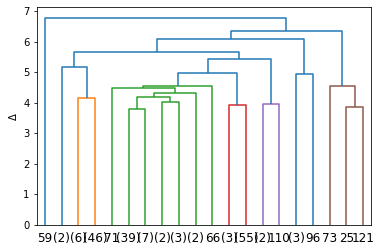

In [55]:
ax = plot1(Z)
ax.figure.savefig('plot1-test.png')
assert compare_images('plot1.png', 'plot1-test.png', tol=50) is None

We assign each point to a flat cluster using `fcluster`.

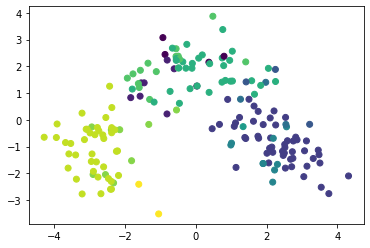

In [61]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=5.8, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 15**

Cluster the newsgroups dataset using Ward's method. What's the best value of $k$? Justify your answer.

**Clustering Newsgroups dataset using Ward's method**

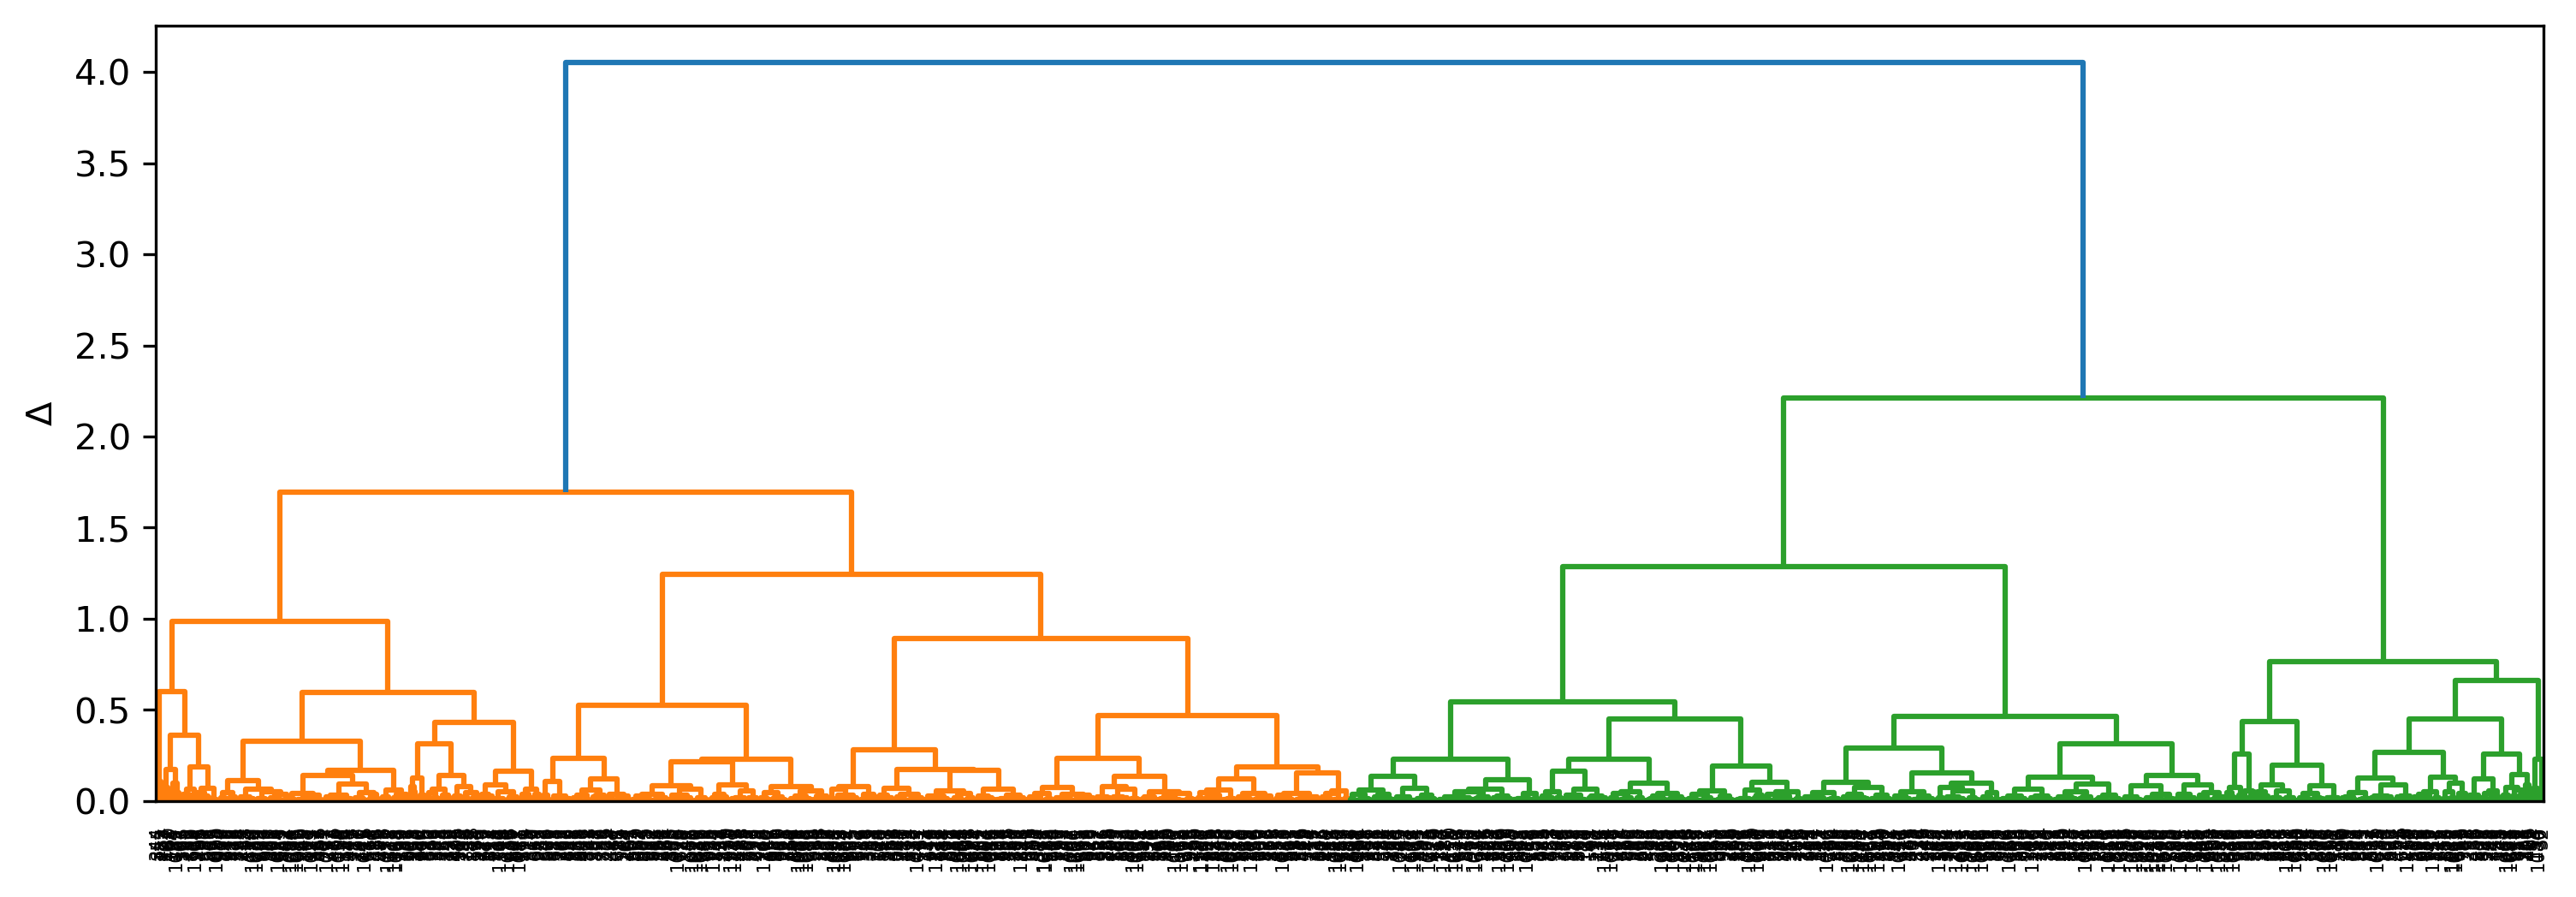

In [40]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Ward's method
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

We can clean up the dendogram above by grouping some points.

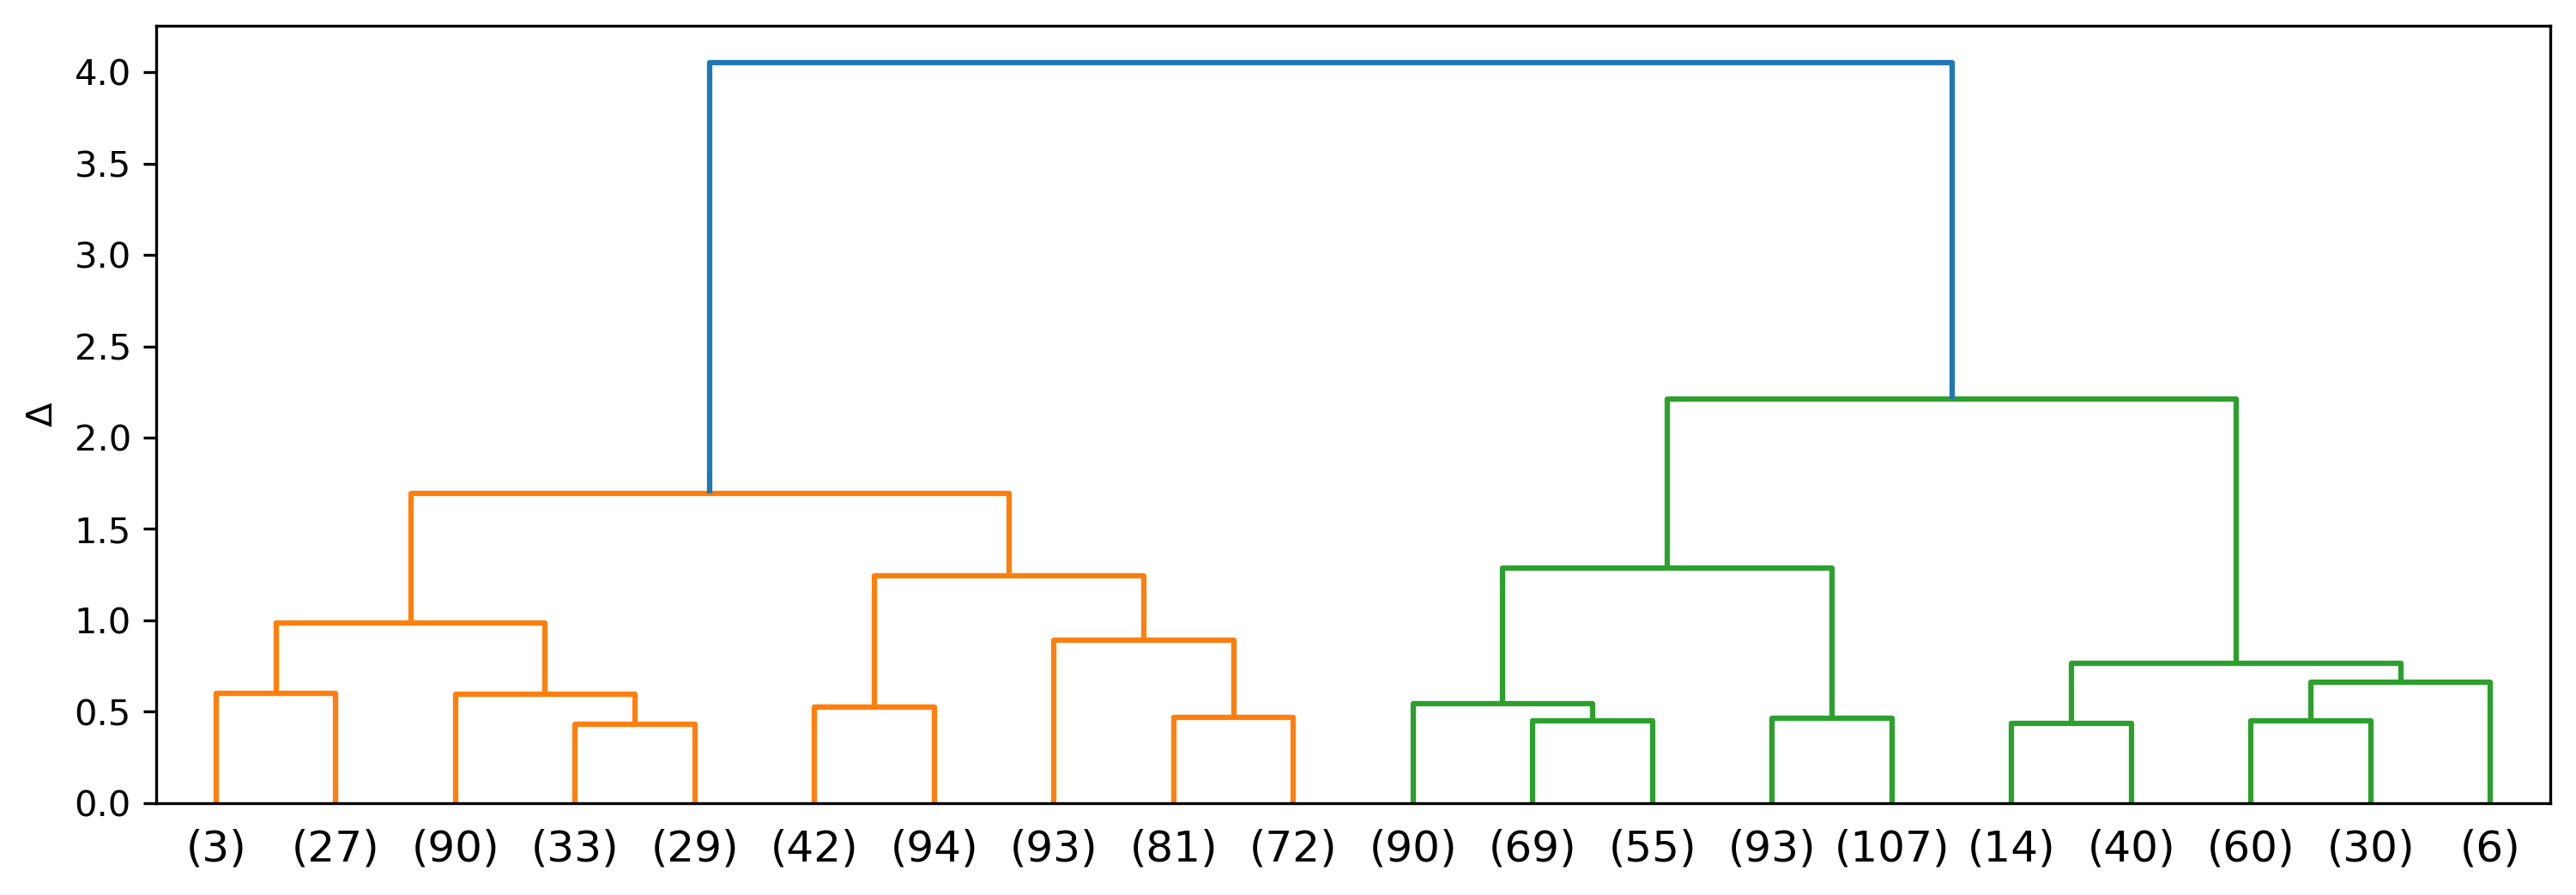

In [41]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Ward's method
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=20, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

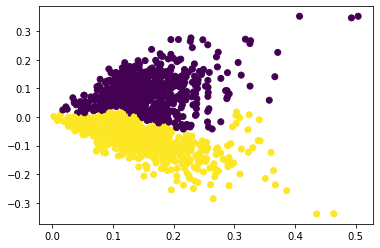

In [45]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=2.5, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

Based on the plots above (dendrogram and scatterplot), I would choose **delta=2.5**. At this level, there is a big gap where there is no merging between clusters. I would also end up with **two** clusters (k). As shown in the catter plot above, the data points appear **balanced** where the number of points in each cluster are comparable. In addition, the points are also **compact** where the points in the same cluster are close together.

## Single linkage

Single linkage uses the smallest intercluster distance as the metric. Let's try it on the wines dataset.

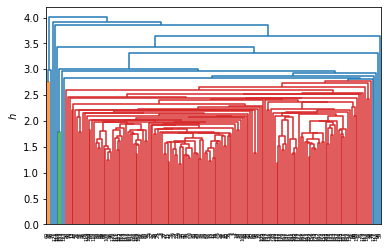

In [46]:
Z = linkage(X_wine, method='single', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

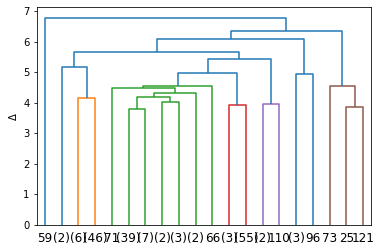

In [47]:
plot1(Z);

This will be the clustering if we set the threshold to 3.

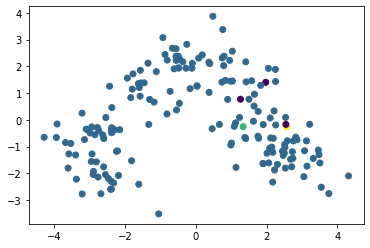

In [48]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=3.7, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 16**

Why is the clustering worse than with Ward's method?

It is worse because the points are **not separable** given the overlaps of the blue, green, yellow, and purple dots. The points are also **not balanced** given that the blue-green dots dominate the cluster, and there are only few points for the rest of the clusters. Lastly, the points are **not compact** given that far-away points (referring to blue-green) are still part of one cluster.

Overall, this clustering is worse because single-linkage only caclulates the similarity based on the closest point; it does not consider the overall structure of the data.

**Exercise 17**

Cluster the newsgroups dataset using single linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

**Clustering Newsgroups dataset using Single-linkage agglomerative clustering**

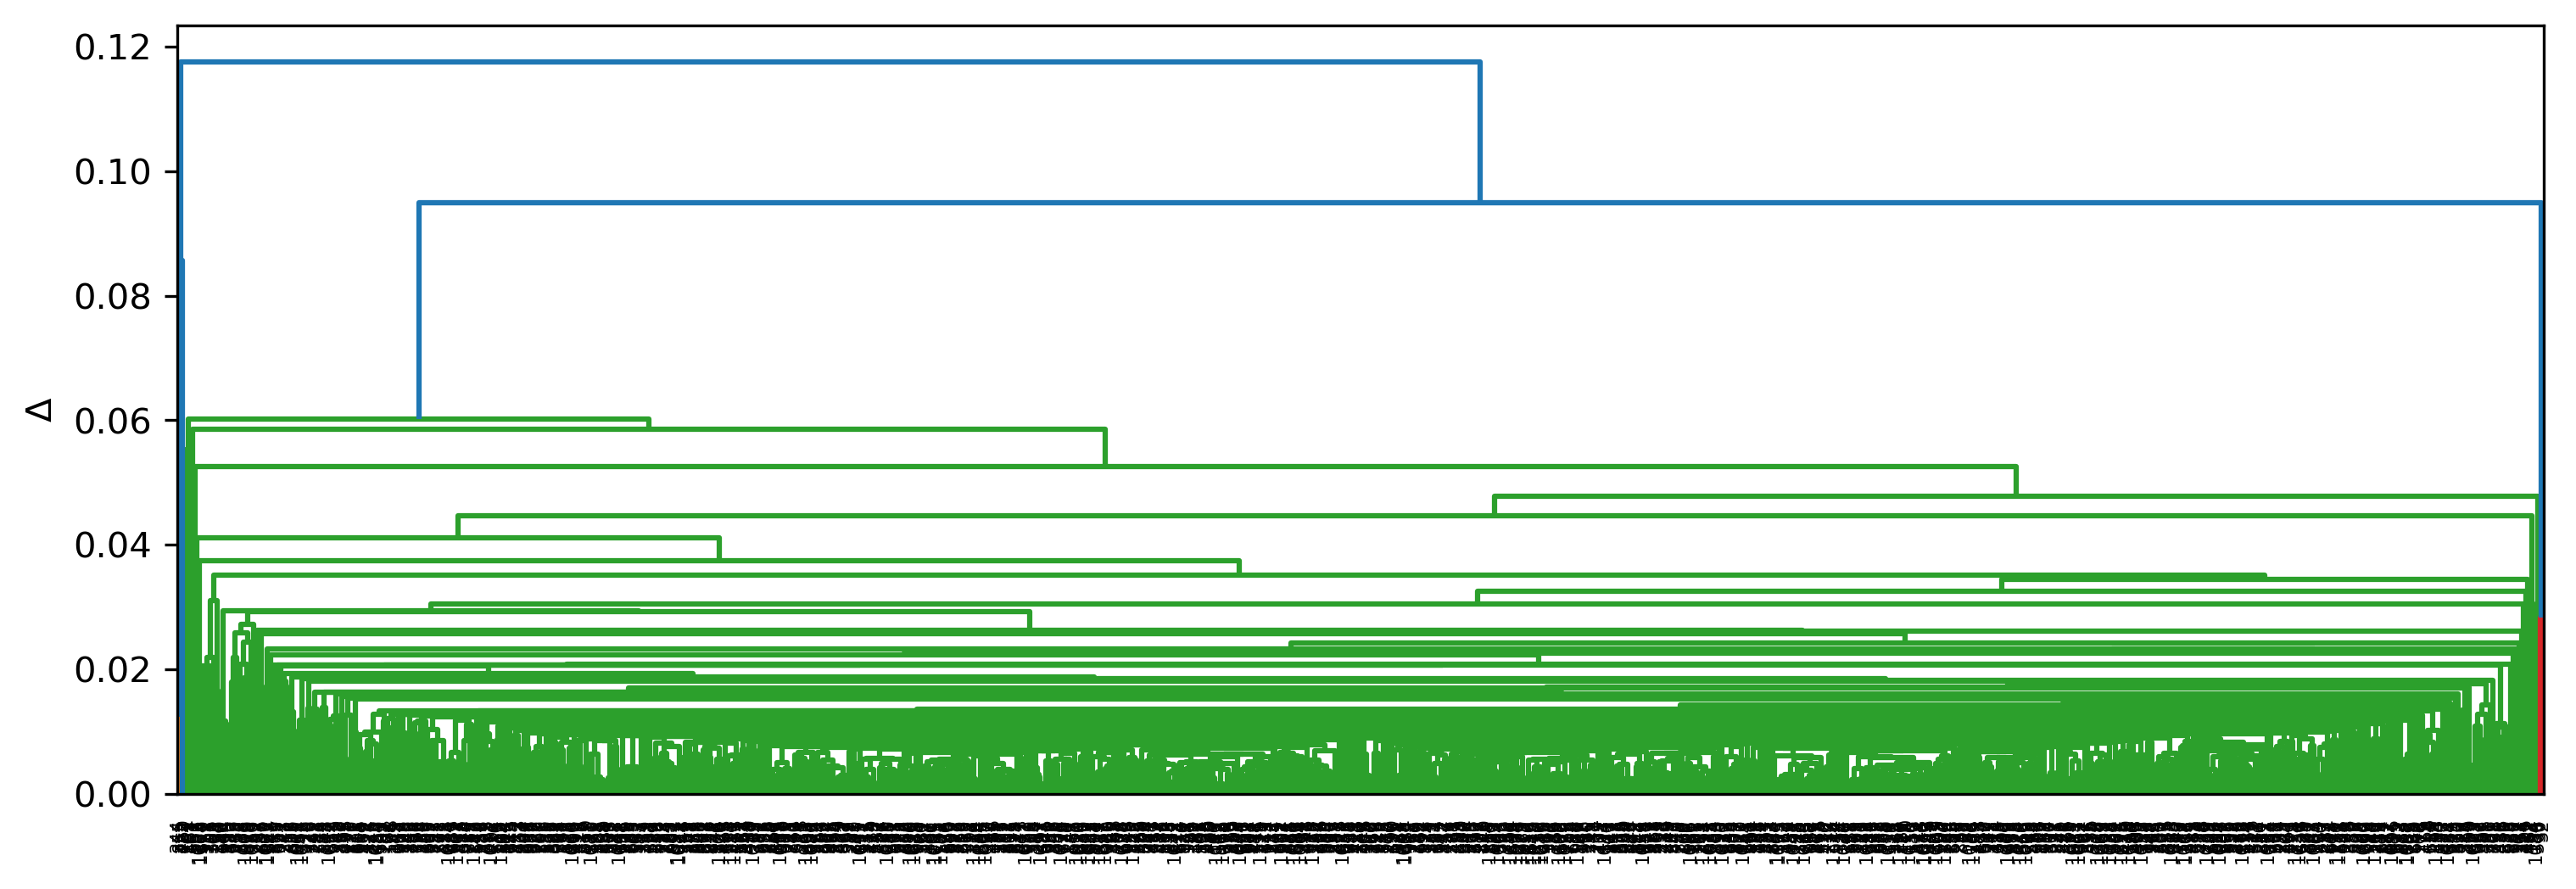

In [49]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Single-linkage
Z = linkage(X_ng_new, method='single', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

We can clean up the dendogram above by grouping some points.

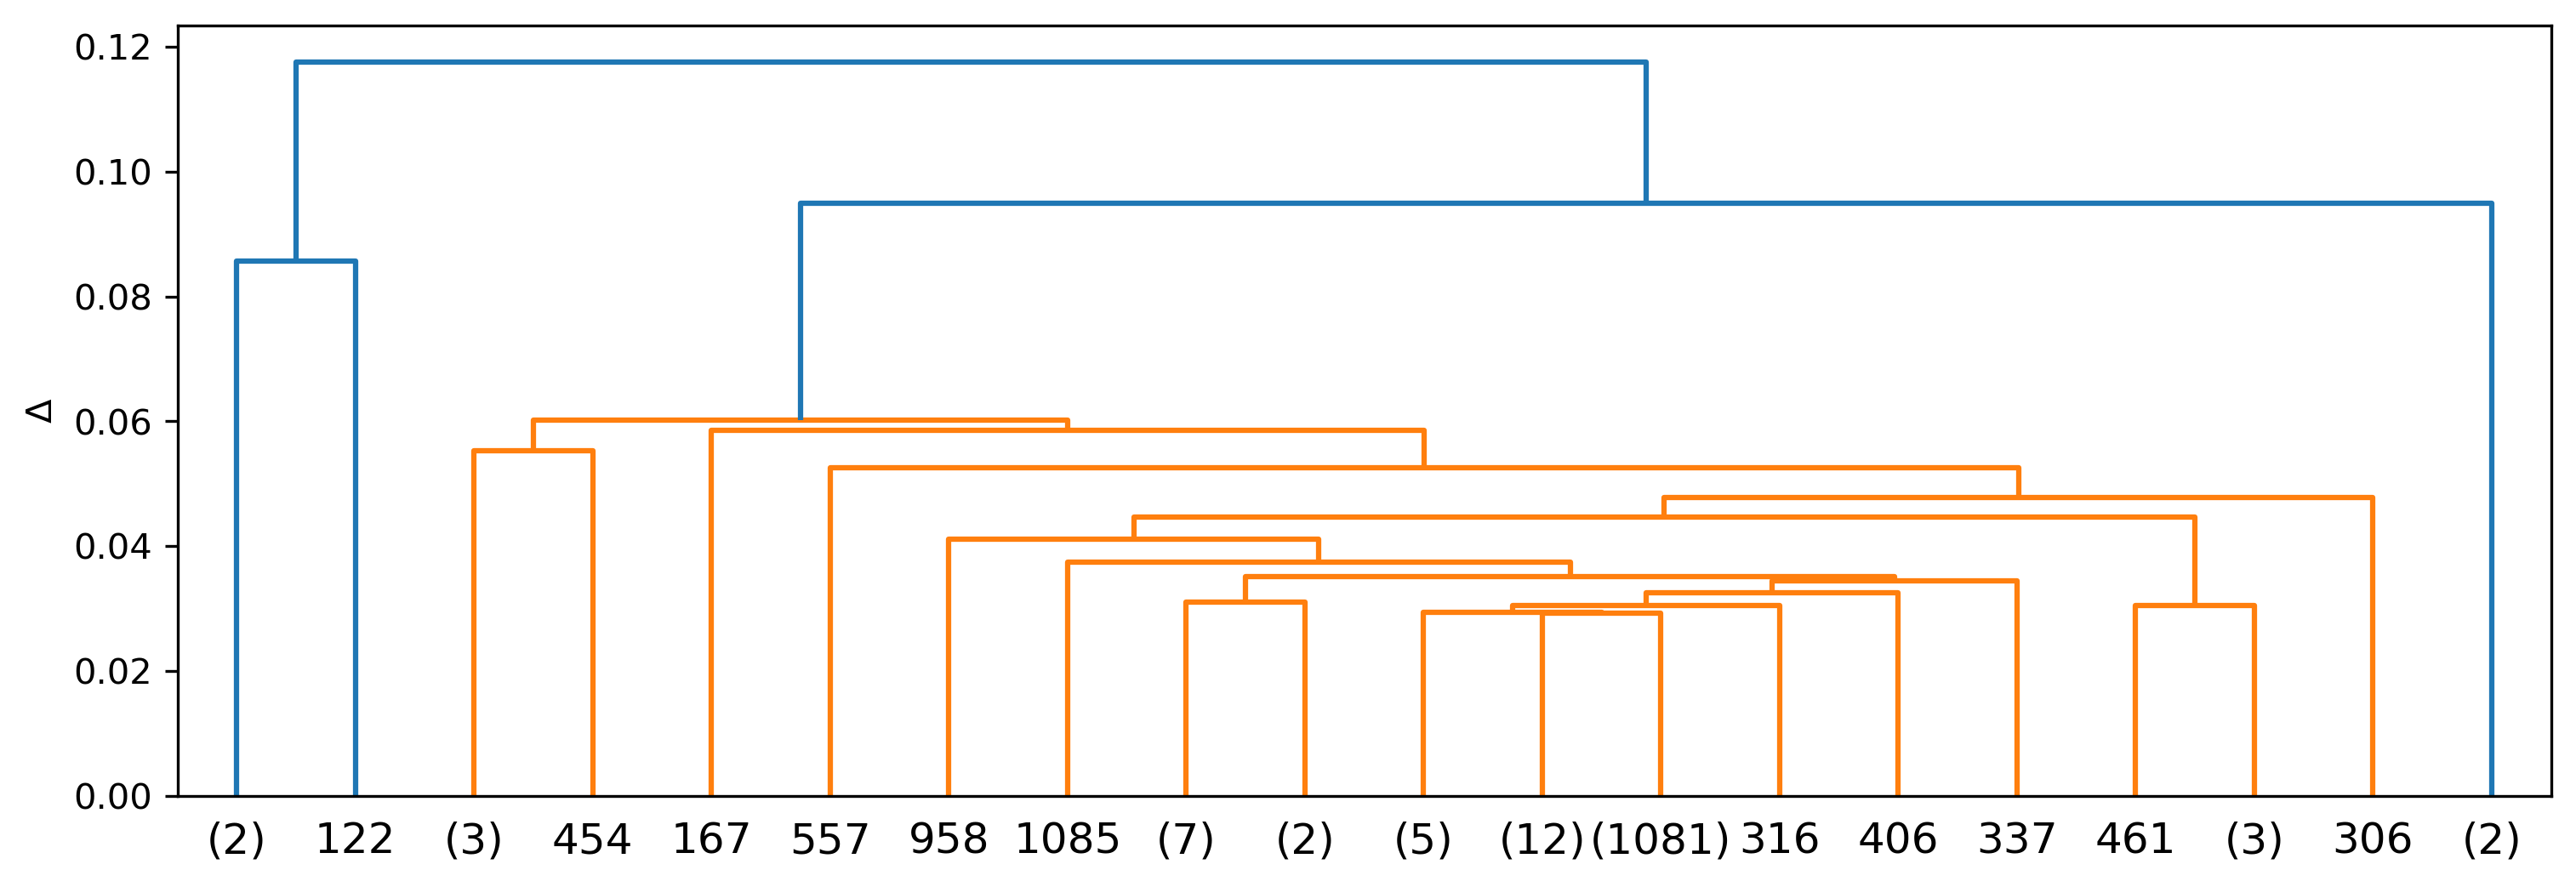

In [50]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Single-linkage
Z = linkage(X_ng_new, method='single', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=20, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

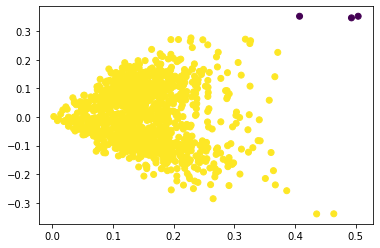

In [53]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=0.1, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

Given that the points are not separable, not balanced, and not compact, it is established that this clustering method does not work well with this data. However, if appointing a k is needed, I would choose a delta (or threshold) at around **0.10**. Upon doing some iterations, this is the delta wherein there is clear separability for the scatterplot. We would end up with **two** clusters (k). It appears that the points in the purple cluster outliers. 

## Complete linkage

Complete linkage uses the largest intercluster distance as the metric. Let's try it on the wines dataset.

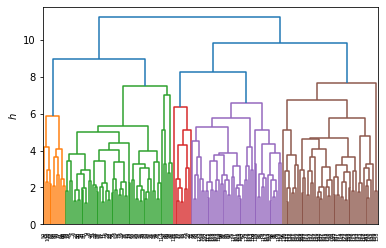

In [56]:
Z = linkage(X_wine, method='complete', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, ax=ax)
ax.set_ylabel(r'$h$');

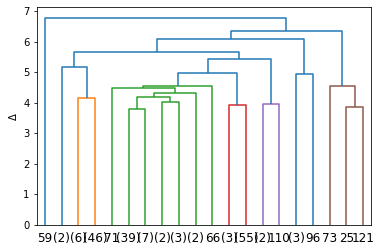

In [57]:
plot1(Z);

This will be the clustering if we set the threshold to 9.

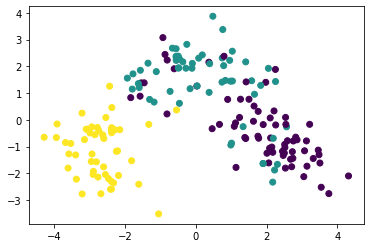

In [62]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=9, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 18**

Compare the clustering with those of Ward's method and single linkage. Is complete linkage better or worse than other methods?

On **separability**:
- Single linkage has worse separability than Complete linkage. Single linkage implies that there is only one large cluster, and there are few overlapping points within the large cluster. Complete linkage has worse separability than Ward's method. In Ward's method, there are only few overlapping points. Whereas here in Complete linkage, almost all points in 2 clusters (blue-green and purple) are evenly overlapped.

On **balance**:
- Single linkage shows no balance; it shows only one dominating cluster. Hence, it is the worst in this aspect among all of the clusters discussed in the notebook. Ward's method and Complete linkage are comparable in terms of balance.

On being **compact**:
- Single linkage is not compact given that it only shows one dominating cluster. The points in Ward's method are more compact than that of Complete linkage. 

Based on these facets, it appears that Complete linkage is worse than Single linkage, but is generally not better than Ward's method.

**Exercise 19**

Cluster the newsgroups dataset using complete linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

**Clustering Newsgroups dataset using Complete-linkage agglomerative clustering**

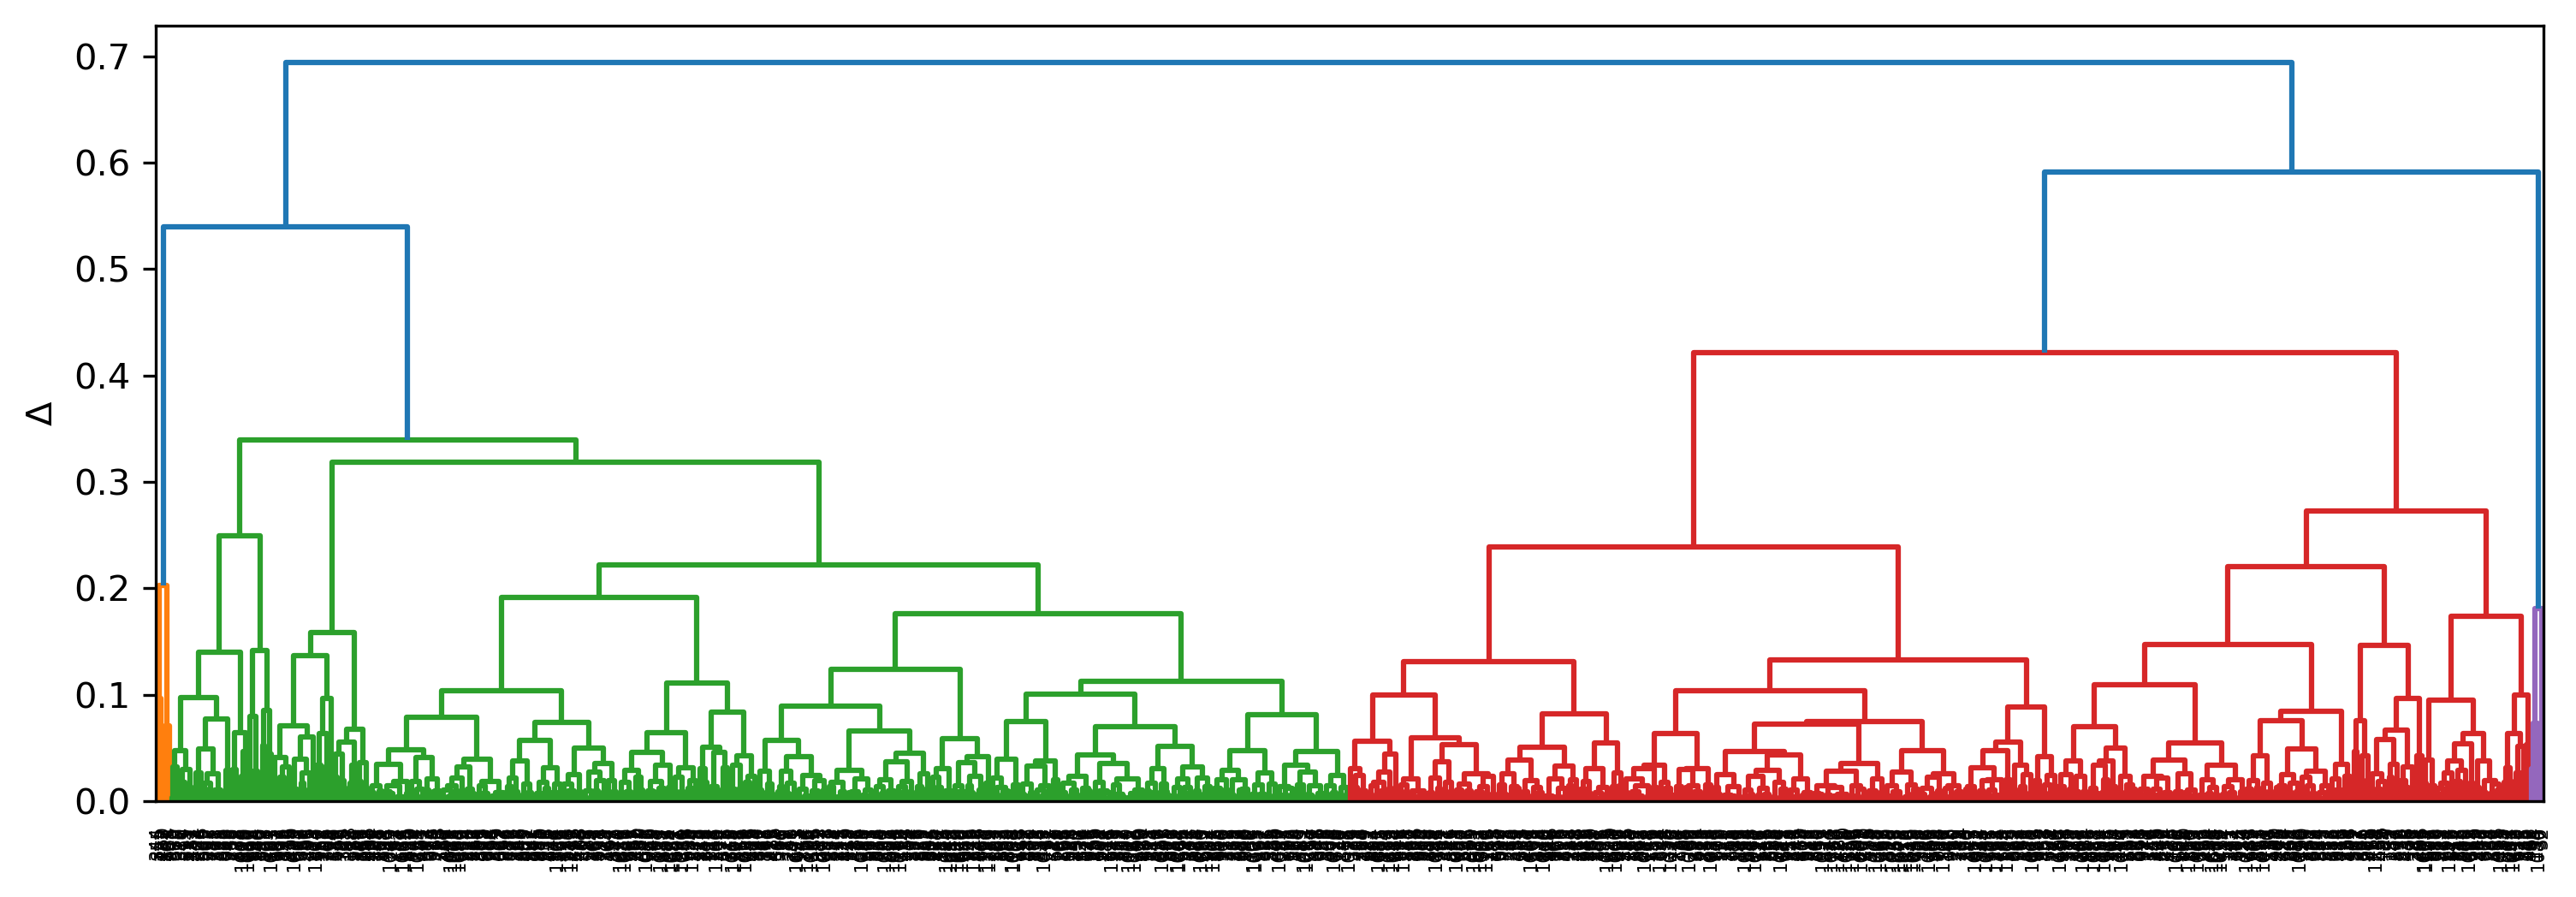

In [64]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Complete-linkage
Z = linkage(X_ng_new, method='complete', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

We can clean up the dendogram above by grouping some points.

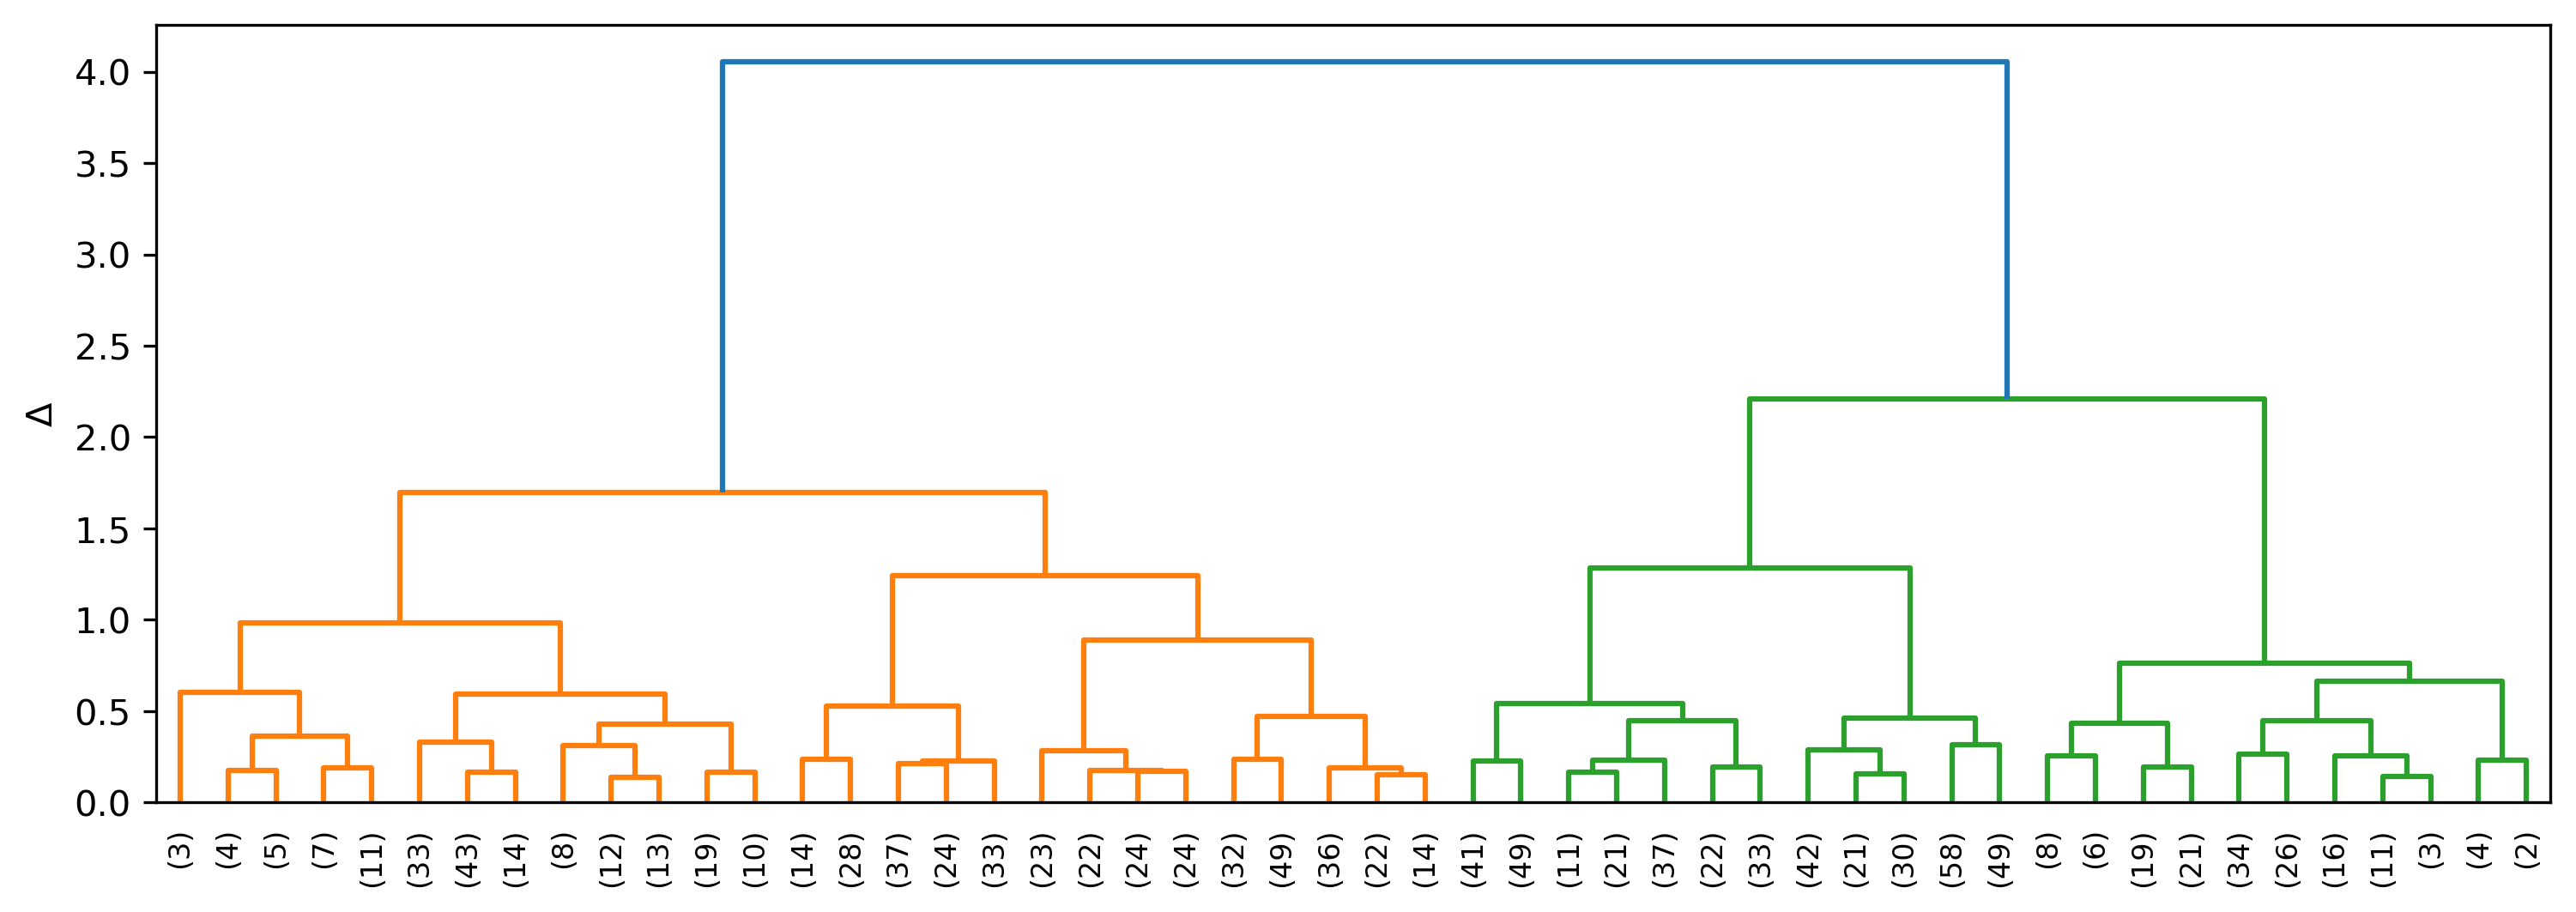

In [71]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Complete-linkage
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=50, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

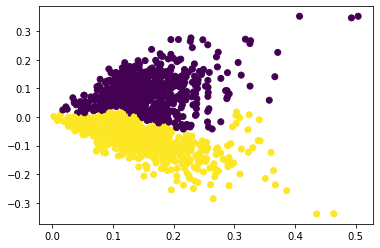

In [86]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=3.0, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

Given the plots above, I am inclined to use a delta (or a threshold) at **around 3.0**. Using delta=3, there are **2** clusters (k). I am choosing this because the clusters appear to be **balanced** (i.e. almost same number of points per cluster), **compact** (i.e. points of the same cluster are close, except for a few outliers), and **parsimonious** (i.e. only few). In the dendogram, this appears to be the delta/threshold where there is less merging across the points. 

## Average linkage

Average linkage uses the average intercluster distance as the metric. Let's try it on the wines dataset.

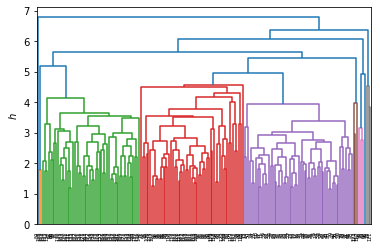

In [87]:
Z = linkage(X_wine, method='average', optimal_ordering=True)
fig, ax = plt.subplots()
dn = dendrogram(Z, color_threshold=4.8, ax=ax)
ax.set_ylabel(r'$h$');

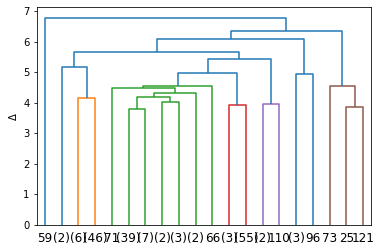

In [88]:
plot1(Z);

This will be the clustering if we set the threshold to 4.5.

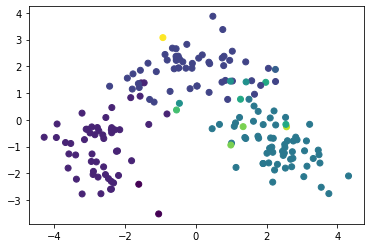

In [90]:
from scipy.cluster.hierarchy import fcluster
y_predict_wine = fcluster(Z, t=4.5, criterion='distance')
plt.scatter(X_wine_new[:,0], X_wine_new[:,1], c=y_predict_wine);

**Exercise 20**

Compare the clustering with those of Ward's method, single linkage and complete linkage. Is average linkage better or worse than other methods?

On **separability**:
- Single-linkage has the worst separability among all clustering methods. Average-linkage's separability is almost comparable with Complete-linkage (which is worse than Ward's method). 

On **balance**:
- Single-linkage shows no balance; the points show only one dominating cluster. Hence, it is the worst in this aspect among all of the clusters discussed in the notebook. Ward's method and Complete-linkage are comparable in terms of balance; these methods are better than Average-linked method.

On being **compact**:
- Single linkage is not compact given that it only shows one dominating cluster. The points in Ward's method are more compact than that of Complete-linkage and Average-linkage.

Based on these facets, Average-linkage is worse than Complete-linkage and Ward's method, but is better than Single-linkage.

**Exercise 21**

Cluster the newsgroups dataset using average linkage agglomerative clustering. What's the best value of $k$? Justify your answer.

**Clustering Newsgroups dataset using Average-linkage agglomerative clustering**

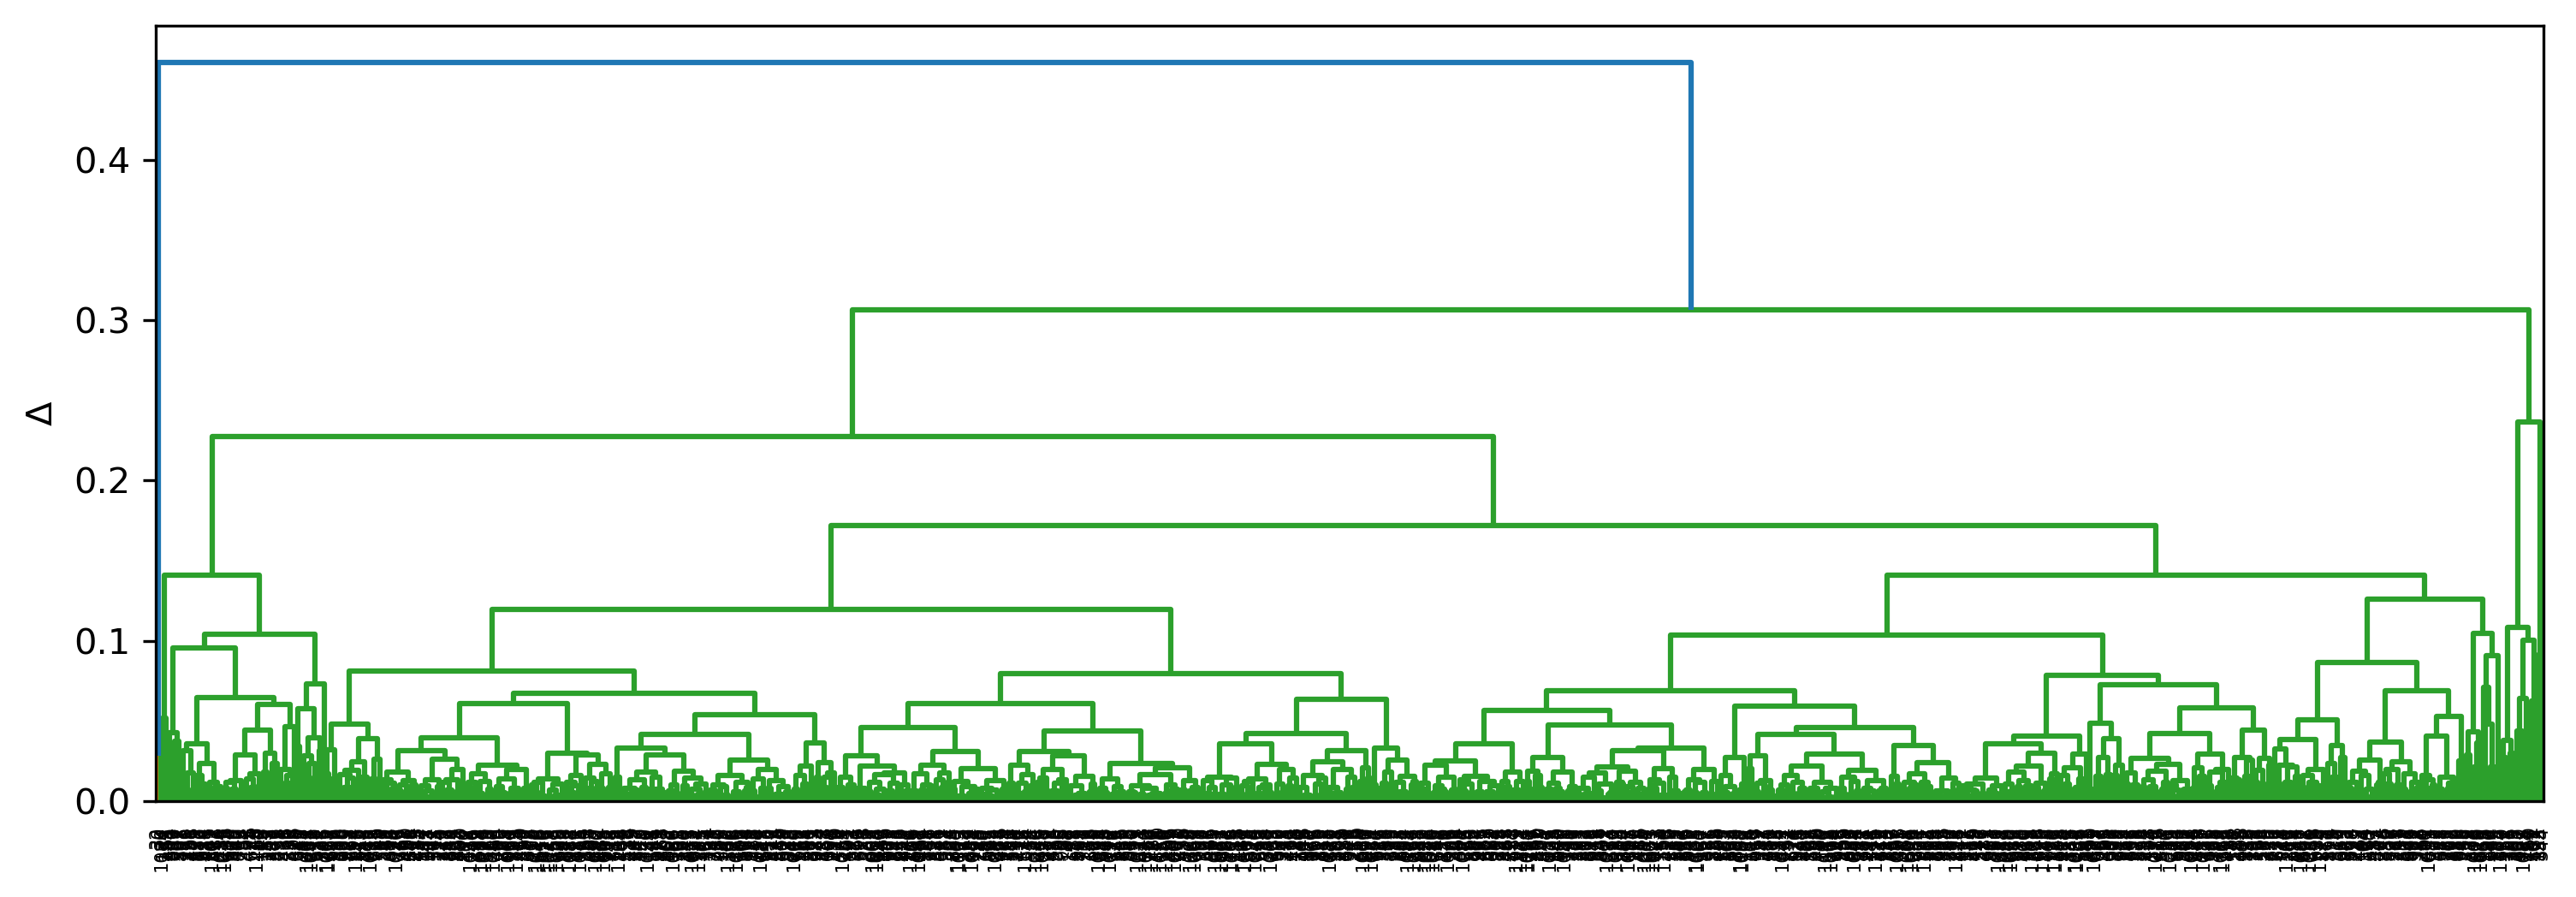

In [91]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Average-linkage method
Z = linkage(X_ng_new, method='average', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

We can clean up the dendogram above by grouping some points.

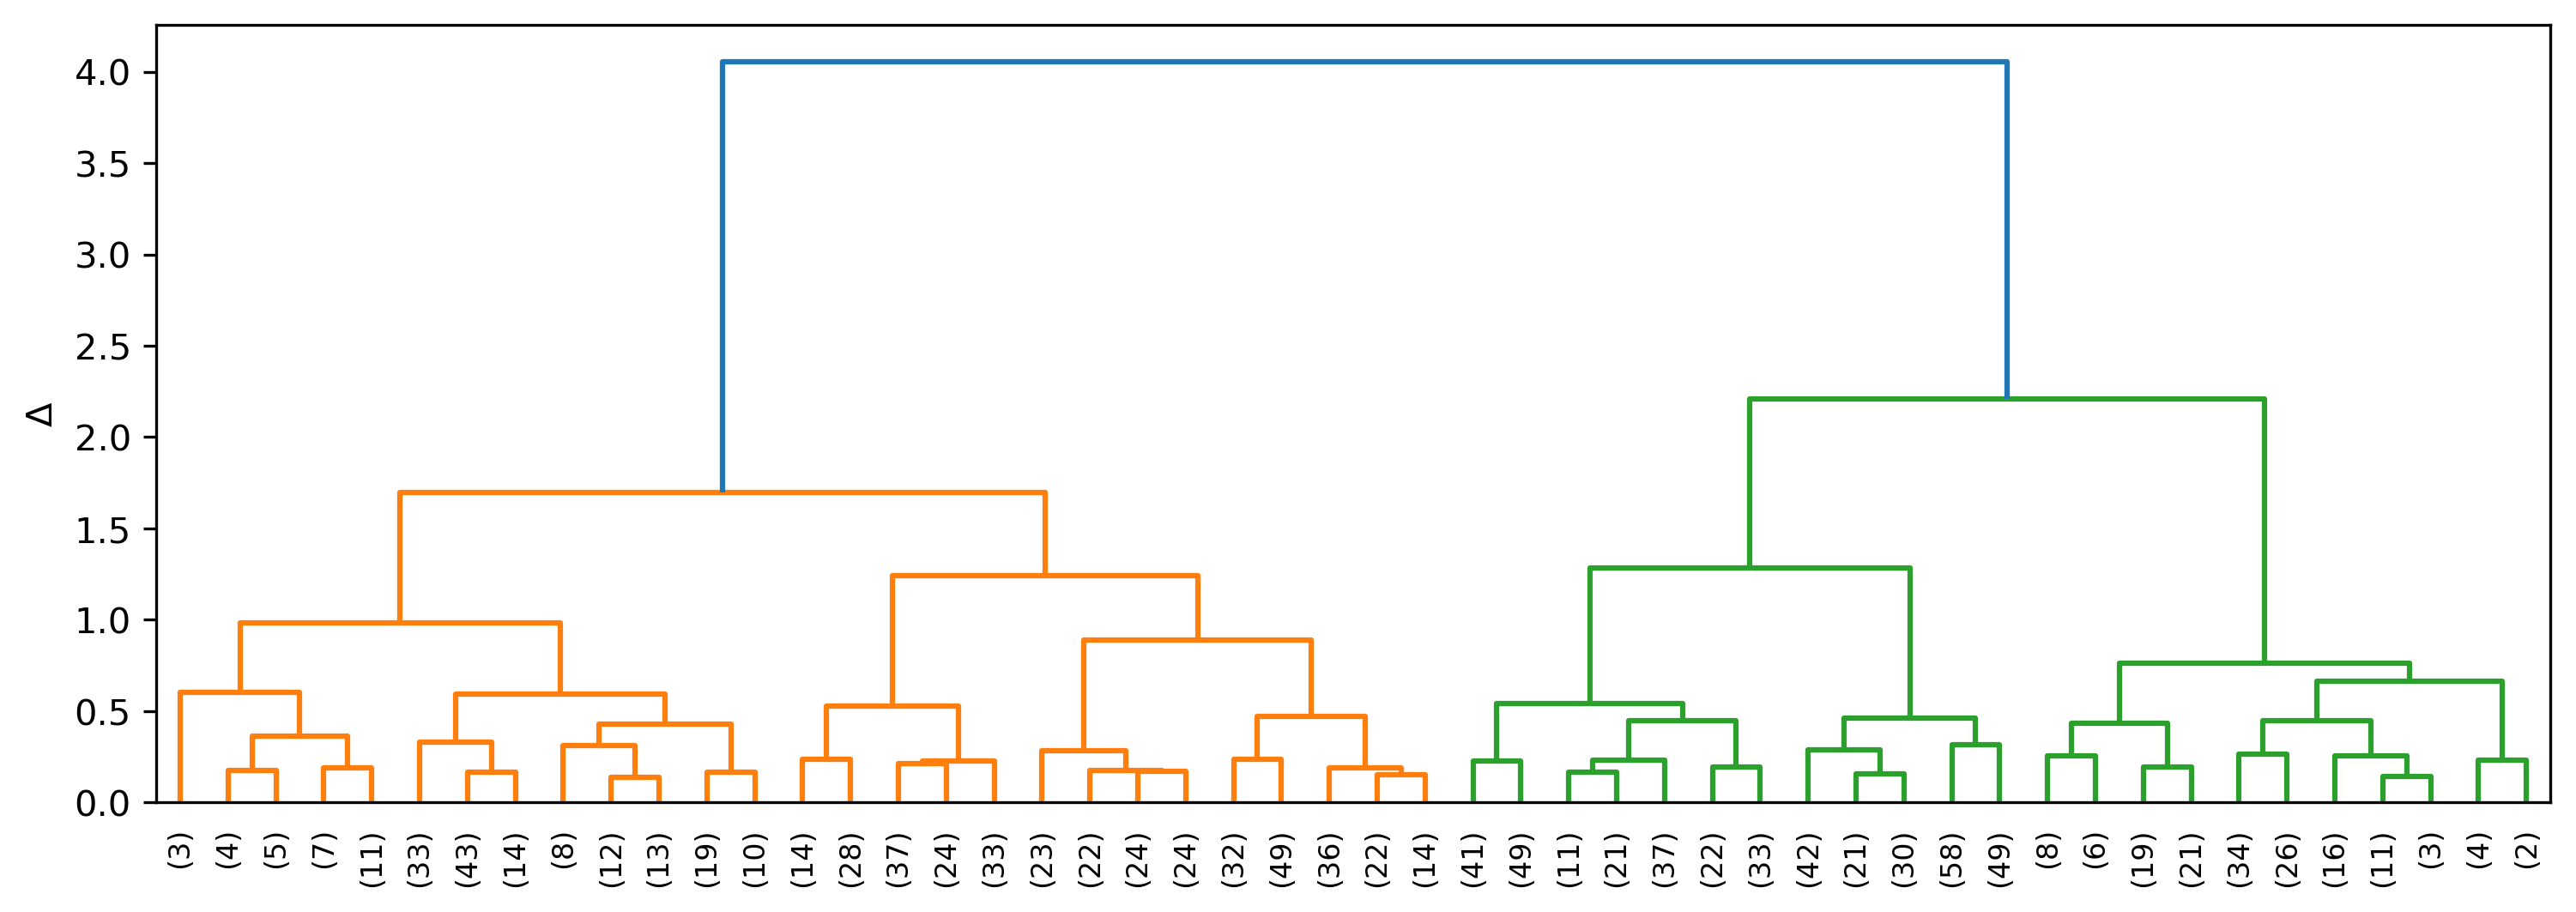

In [92]:
# Import packages
from scipy.cluster.hierarchy import linkage, dendrogram

# Form linkage matrix using Average-linkage method
Z = linkage(X_ng_new, method='ward', optimal_ordering=True)

# Set up subplot
fig, ax = plt.subplots(figsize=(12,4), dpi=300)

# Set the plot as dendigram
dn = dendrogram(Z, truncate_mode='lastp', p=50, ax=ax)

# Set y label as 'Delta'
ax.set_ylabel(r'$\Delta$');

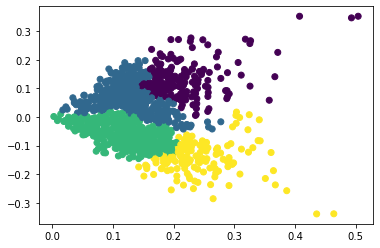

In [99]:
# Check clustering through scatterplot
from scipy.cluster.hierarchy import fcluster

# Choosing a delta of 2 for scatterplot
y_predict_ng = fcluster(Z, t=1.5, criterion='distance')
plt.scatter(X_ng_new[:,0], X_ng_new[:,1], c=y_predict_ng);

Based on the plots above, I am inclined to use a delta (or a threshold) of **around 1.5**. Using delta=1.5, there are **4** clusters (k). In the dendogram, this appears to be the delta/threshold where there is less merging across the points. In addition, the scatterplot shows that the points are **compact** and that the outliers generally have their own cluster. 

# References
* C. Shalizi, Statistics 36-350 lecture notes, http://www.stat.cmu.edu/~cshalizi/350/lectures/07/lecture-07.pdf
* C. Aggarwal, Data Mining: The Textbook, Chapter 6.